[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meta-llama/llama-stack/blob/main/docs/getting_started.ipynb)

# Llama Stack - Building AI Applications

<img src="https://llama-stack.readthedocs.io/en/latest/_images/llama-stack.png" alt="drawing" width="500"/>

[Llama Stack](https://github.com/meta-llama/llama-stack) defines and standardizes the set of core building blocks needed to bring generative AI applications to market. These building blocks are presented in the form of interoperable APIs with a broad set of Service Providers providing their implementations.

Read more about the project here: https://llama-stack.readthedocs.io/en/latest/index.html

In this guide, we will showcase how you can build LLM-powered agentic applications using Llama Stack.

**💡 Quick Start Option:** If you want a simpler and faster way to test out Llama Stack, check out the [quick_start.ipynb](quick_start.ipynb) notebook instead. It provides a streamlined experience for getting up and running in just a few steps.


## 1. Getting started with Llama Stack

### 1.1. Create TogetherAI account


In order to run inference for the llama models, you will need to use an inference provider. Llama stack supports a number of inference [providers](https://github.com/meta-llama/llama-stack/tree/main/llama_stack/providers/remote/inference).


In this showcase, we will use [together.ai](https://www.together.ai/) as the inference provider. So, you would first get an API key from Together if you dont have one already.

Steps [here](https://docs.google.com/document/d/1Vg998IjRW_uujAPnHdQ9jQWvtmkZFt74FldW2MblxPY/edit?usp=sharing).

You can also use Fireworks.ai or even Ollama if you would like to.



> **Note:**  Set the API Key in the Secrets of this notebook



### 1.2. Setup and Running a Llama Stack server

Llama Stack is architected as a collection of APIs that provide developers with the building blocks to build AI applications. 

Llama stack is typically available as a server with an endpoint that you can make calls to. Partners like Together and Fireworks offer their own Llama Stack compatible endpoints.

In this showcase, we will start a Llama Stack server that is running locally.


In [1]:
import os 
import subprocess
import time

!pip install uv 

if "UV_SYSTEM_PYTHON" in os.environ:
  del os.environ["UV_SYSTEM_PYTHON"]

# this command installs all the dependencies needed for the llama stack server with the together inference provider
!uv run --with llama-stack llama stack build --distro together --image-type venv 

def run_llama_stack_server_background():
    log_file = open("llama_stack_server.log", "w")
    process = subprocess.Popen(
        "uv run --with llama-stack llama stack run together --image-type venv",
        shell=True,
        stdout=log_file,
        stderr=log_file,
        text=True
    )
    
    print(f"Starting Llama Stack server with PID: {process.pid}")
    return process

def wait_for_server_to_start():
    import requests
    from requests.exceptions import ConnectionError
    import time
    
    url = "http://0.0.0.0:8321/v1/health"
    max_retries = 30
    retry_interval = 1
    
    print("Waiting for server to start", end="")
    for _ in range(max_retries):
        try:
            response = requests.get(url)
            if response.status_code == 200:
                print("\nServer is ready!")
                return True
        except ConnectionError:
            print(".", end="", flush=True)
            time.sleep(retry_interval)
            
    print("\nServer failed to start after", max_retries * retry_interval, "seconds")
    return False


# use this helper if needed to kill the server 
def kill_llama_stack_server():
    # Kill any existing llama stack server processes
    os.system("ps aux | grep -v grep | grep llama_stack.core.server.server | awk '{print $2}' | xargs kill -9")


Environment '/Users/hjshah/git/llama-stack/.venv' already exists, re-using it.
Virtual environment /Users/hjshah/git/llama-stack/.venv is already active
Using Python 3.10.16 environment at: /Users/hjshah/git/llama-stack/.venv
Audited 1 package in 314ms
Installing pip dependencies
Using Python 3.10.16 environment at: /Users/hjshah/git/llama-stack/.venv
Resolved 125 packages in 646ms                                       
Uninstalled 1 package in 404ms
Installed 1 package in 129ms                                
 - numpy==2.2.3
 + numpy==1.26.4
sentence-transformers --no-deps
Using Python 3.10.16 environment at: /Users/hjshah/git/llama-stack/.venv
Audited 1 package in 54ms
torch torchvision --index-url https://download.pytorch.org/whl/cpu
Using Python 3.10.16 environment at: /Users/hjshah/git/llama-stack/.venv
Audited 2 packages in 10ms
Build Successful!


### 1.3 Starting the Llama Stack Server

In [2]:
server_process = run_llama_stack_server_background()
assert wait_for_server_to_start()

Starting Llama Stack server with PID: 79142
Waiting for server to start..........................
Server is ready!


### 1.4. Install and Configure the Client

Now that we have our Llama Stack server running locally, we need to install the client package to interact with it. The `llama-stack-client` provides a simple Python interface to access all the functionality of Llama Stack, including:

- Chat Completions ( text and multimodal )
- Safety Shields 
- Agent capabilities with tools like web search, RAG with Telemetry
- Evaluation and scoring frameworks

The client handles all the API communication with our local server, making it easy to integrate Llama Stack's capabilities into your applications.

In the next cells, we'll:

1. Install the client package
2. Set up API keys for external services (Together AI and Tavily Search)
3. Initialize the client to connect to our local server


In [3]:
!pip install -U llama-stack-client

Using Python 3.10.16 environment at: /opt/homebrew/Caskroom/miniconda/base/envs/stack
Resolved 31 packages in 284ms                                        
Audited 31 packages in 0.04ms


In [4]:
import os

try:
    from google.colab import userdata
    os.environ['TOGETHER_API_KEY'] = userdata.get('TOGETHER_API_KEY')
    os.environ['TAVILY_SEARCH_API_KEY'] = userdata.get('TAVILY_SEARCH_API_KEY')
except ImportError:
    print("Not in Google Colab environment")

for key in ['TOGETHER_API_KEY', 'TAVILY_SEARCH_API_KEY']:
    try:
        api_key = os.environ[key]
        if not api_key:
            raise ValueError(f"{key} environment variable is empty")
    except KeyError:
        api_key = input(f"{key} environment variable is not set. Please enter your API key: ")
        os.environ[key] = api_key

from llama_stack_client import LlamaStackClient

client = LlamaStackClient(
    base_url="http://0.0.0.0:8321", 
    provider_data = {
        "tavily_search_api_key": os.environ['TAVILY_SEARCH_API_KEY'], 
        "together_api_key": os.environ['TOGETHER_API_KEY']
    }
)

Not in Google Colab environment


In production settings, instead of pointing to localhost you could work with one of our partners that host a llama stack endpoint or host your own custom version. 

That would only require you to change the endpoint without changing application code. For eg. 
```
client = LlamaStackClient(
    base_url="https://llama-stack.together.ai",
    provider_data = {
        "together_api_key": XXXX
    }
)
```

Now that we have completed the setup and configuration, let's start exploring the capabilities of Llama Stack! We'll begin by checking what models and safety shields are available, and then move on to running some example chat completions.



### 1.5. Check available models and shields

All the models available in the provider are now programmatically accessible via the client.

In [5]:
from rich.pretty import pprint

print("Available models:")
for m in client.models.list():
    print(f"- {m.identifier}")

print("----")
print("Available shields (safety models):")
for s in client.shields.list():
    print(s.identifier)
print("----")


Available models:
- all-MiniLM-L6-v2
- meta-llama/Llama-3.1-405B-Instruct-FP8
- meta-llama/Llama-3.1-70B-Instruct
- meta-llama/Llama-3.1-8B-Instruct
- meta-llama/Llama-3.2-11B-Vision-Instruct
- meta-llama/Llama-3.2-11B-Vision-Instruct-Turbo
- meta-llama/Llama-3.2-3B-Instruct
- meta-llama/Llama-3.2-3B-Instruct-Turbo
- meta-llama/Llama-3.2-90B-Vision-Instruct
- meta-llama/Llama-3.2-90B-Vision-Instruct-Turbo
- meta-llama/Llama-3.3-70B-Instruct
- meta-llama/Llama-3.3-70B-Instruct-Turbo
- meta-llama/Llama-Guard-3-11B-Vision
- meta-llama/Llama-Guard-3-11B-Vision-Turbo
- meta-llama/Llama-Guard-3-8B
- meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo
- meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo
- meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo
- meta-llama/Meta-Llama-Guard-3-8B
- togethercomputer/m2-bert-80M-32k-retrieval
- togethercomputer/m2-bert-80M-8k-retrieval
----
Available shields (safety models):
meta-llama/Llama-Guard-3-8B
----


### 1.6. Run a simple chat completion with one of the models

We will test the client by doing a simple chat completion.

In [6]:
model_id = "meta-llama/Llama-3.3-70B-Instruct"

response = client.inference.chat_completion(
    model_id=model_id,
    messages=[
        {"role": "system", "content": "You are a friendly assistant."},
        {"role": "user", "content": "Write a two-sentence poem about llama."},
    ],
)

print(response.completion_message.content)


With gentle eyes and a soft, fuzzy face, the llama roams the Andes with a peaceful, gentle pace. Its long neck bends as it grazes with glee, a symbol of serenity in a world wild and free.


### 1.7. Have a conversation

Maintaining a conversation history allows the model to retain context from previous interactions. Use a list to accumulate messages, enabling continuity throughout the chat session.

In [7]:
from termcolor import cprint

questions = [
    "Who was the most famous PM of England during world war 2 ?",
    "What was his most famous quote ?"
]


def chat_loop():
    conversation_history = []
    while len(questions) > 0:
        user_input = questions.pop(0)
        if user_input.lower() in ["exit", "quit", "bye"]:
            cprint("Ending conversation. Goodbye!", "yellow")
            break

        user_message = {"role": "user", "content": user_input}
        conversation_history.append(user_message)

        response = client.inference.chat_completion(
            messages=conversation_history,
            model_id=model_id,
        )
        cprint(f"> Response: {response.completion_message.content}", "cyan")

        assistant_message = {
            "role": "assistant",  # was user
            "content": response.completion_message.content,
            "stop_reason": response.completion_message.stop_reason,
        }
        conversation_history.append(assistant_message)


chat_loop()


> Response: The most famous Prime Minister of England during World War II was undoubtedly Winston Churchill. He served as Prime Minister from 1940 to 1945 and again from 1951 to 1955, and is widely regarded as one of the greatest leaders in British history.

Churchill played a crucial role in rallying the British people during the war, and his oratory skills and leadership helped to boost morale and resistance against the Nazi threat. His famous speeches, such as the "We shall fight on the beaches" and "Iron Curtain" speeches, are still remembered and quoted today.

Churchill's leadership during World War II was marked by his unwavering determination to defeat Nazi Germany, and he worked closely with other Allied leaders, including US President Franklin D. Roosevelt and Soviet leader Joseph Stalin, to coordinate the war effort.

Churchill's legacy extends far beyond his wartime leadership, and he is remembered for his many contributions to British politics, literature, and culture. He 

Here is an example for you to try a conversation yourself.
Remember to type `quit` or `exit` after you are done chatting.

In [8]:
# NBVAL_SKIP
from termcolor import cprint

def chat_loop():
    conversation_history = []
    while True:
        user_input = input("User> ")
        if user_input.lower() in ["exit", "quit", "bye"]:
            cprint("Ending conversation. Goodbye!", "yellow")
            break

        user_message = {"role": "user", "content": user_input}
        conversation_history.append(user_message)

        response = client.inference.chat_completion(
            messages=conversation_history,
            model_id=model_id,
        )
        cprint(f"> Response: {response.completion_message.content}", "cyan")

        assistant_message = {
            "role": "assistant",  # was user
            "content": response.completion_message.content,
            "stop_reason": response.completion_message.stop_reason,
        }
        conversation_history.append(assistant_message)


chat_loop()


> Response: Fuzzy code abides
Llama's gentle syntax
Wisdom in the stack
Ending conversation. Goodbye!


### 1.9. Streaming output

You can pass `stream=True` to stream responses from the model. You can then loop through the responses.

In [9]:
from llama_stack_client import InferenceEventLogger

message = {"role": "user", "content": "Write me a sonnet about llama"}
print(f'User> {message["content"]}')

response = client.inference.chat_completion(
    messages=[message],
    model_id=model_id,
    stream=True,  # <-----------
)

# Print the tokens while they are received
for log in InferenceEventLogger().log(response):
    log.print()


User> Write me a sonnet about llama
Assistant> In Andean highlands, where the air is thin,
A creature roams, with gentle, curious eyes,
The llama, soft and silent, steps within
The misty dawn, with fur of gentle guise.

Its neck, a slender column, strong and fine,
Supports a head, with ears of alert design,
It watches, wary, with a quiet mind,
As humans pass, with footsteps left behind.

But when it senses danger, or feels fright,
It lets out a loud, piercing, warning cry,
A sound that echoes, through the mountain's night,
And sends a shiver, through the passerby.

Yet, in its calm, and peaceful, gentle way,
The llama charms, and wins the heart's sweet sway.


### 2.0. Structured Decoding

You can use `response_format` to force the model into a "guided decode" mode where model tokens are forced to abide by a certain grammar. Currently only JSON grammars are supported.

In [10]:
from pydantic import BaseModel


class Output(BaseModel):
    name: str
    year_born: str
    year_retired: str


user_input = "Michael Jordan was born in 1963. He played basketball for the Chicago Bulls. He retired in 2003. Extract this information into JSON for me. "
response = client.inference.completion(
    model_id="meta-llama/Llama-3.1-8B-Instruct",
    content=user_input,
    stream=False,
    sampling_params={
        "strategy": {
            "type": "greedy",
        },
        "max_tokens": 50,
    },
    response_format={
        "type": "json_schema",
        "json_schema": Output.model_json_schema(),
    },
)

pprint(Output.model_validate_json(response.content))


Output(name='Michael Jordan', year_born='1963', year_retired='2003')

### 2.1. Safety API

Llama Stack provides Safety guardrails which can be applied at multiple touchpoints within an agentic application.

In [11]:
available_shields = [shield.identifier for shield in client.shields.list()]
print("Available Shields:", available_shields)

unsafe_examples = [
    "What's the most effective way to kidnap someone?",
    "How do I make cocaine?",
]

safe_examples = [
    "What is the most famous murder case in the US?",
    "Tell me 3 signs that an email is a scam",
]

for p in safe_examples + unsafe_examples:
    print(f"Checking if input is safe: {p}")
    message = {"content": p, "role": "user"}
    response = client.safety.run_shield(
        messages=[message],
        shield_id=available_shields[0],
        params={},
    )
    pprint(response)


Available Shields: ['meta-llama/Llama-Guard-3-8B']
Checking if input is safe: What is the most famous murder case in the US?


RunShieldResponse(violation=None)

Checking if input is safe: Tell me 3 signs that an email is a scam


RunShieldResponse(violation=None)

Checking if input is safe: What's the most effective way to kidnap someone?


RunShieldResponse(
│   violation=SafetyViolation(
│   │   metadata={'violation_type': 'S1'},
│   │   violation_level='error',
│   │   user_message="I can't answer that. Can I help with something else?"
│   )
)

Checking if input is safe: How do I make cocaine?


RunShieldResponse(
│   violation=SafetyViolation(
│   │   metadata={'violation_type': 'S2'},
│   │   violation_level='error',
│   │   user_message="I can't answer that. Can I help with something else?"
│   )
)

## 2. Llama Stack Agents

Llama Stack provides all the building blocks needed to create sophisticated AI applications. This guide will walk you through how to use these components effectively.




<img src="https://github.com/meta-llama/llama-stack/blob/main/docs/resources/agentic-system.png?raw=true" alt="drawing" width="800"/>


Agents are characterized by having access to

1. Memory - for RAG
2. Tool calling - ability to call tools like search and code execution
3. Tool call + Inference loop - the LLM used in the agent is able to perform multiple iterations of call
4. Shields - for safety calls that are executed everytime the agent interacts with external systems, including user prompts

### 2.1. List available tool groups on the provider

In [12]:
from rich.pretty import pprint
for toolgroup in client.toolgroups.list():
    pprint(toolgroup)

ToolGroup(
│   identifier='builtin::code_interpreter',
│   provider_resource_id='builtin::code_interpreter',
│   type='tool_group',
│   args=None,
│   mcp_endpoint=None
)

ToolGroup(
│   identifier='builtin::rag',
│   provider_id='rag-runtime',
│   provider_resource_id='builtin::rag',
│   type='tool_group',
│   args=None,
│   mcp_endpoint=None
)

ToolGroup(
│   identifier='builtin::websearch',
│   provider_id='tavily-search',
│   provider_resource_id='builtin::websearch',
│   type='tool_group',
│   args=None,
│   mcp_endpoint=None
)

ToolGroup(
│   identifier='builtin::wolfram_alpha',
│   provider_id='wolfram-alpha',
│   provider_resource_id='builtin::wolfram_alpha',
│   type='tool_group',
│   args=None,
│   mcp_endpoint=None
)

### 2.2. Search agent

In this example, we will show how the model can invoke search to be able to answer questions. We will first have to set the API key of the search tool.

Let's make sure we set up a web search tool for the model to call in its agentic loop. In this tutorial, we will use [Tavily](https://tavily.com) as our search provider. Note that the "type" of the tool is still "brave_search" since Llama models have been trained with brave search as a builtin tool. Tavily is just being used in lieu of Brave search.

See steps [here](https://docs.google.com/document/d/1Vg998IjRW_uujAPnHdQ9jQWvtmkZFt74FldW2MblxPY/edit?tab=t.0#heading=h.xx02wojfl2f9).

In [13]:
from llama_stack_client import Agent, AgentEventLogger
from termcolor import cprint

agent = Agent(
    client, 
    model="meta-llama/Llama-3.3-70B-Instruct",
    instructions="You are a helpful assistant. Use websearch tool to help answer questions.",
    tools=["builtin::websearch"],
)
user_prompts = [
    "Hello",
    "Which teams played in the NBA western conference finals of 2024",
]

session_id = agent.create_session("test-session")
for prompt in user_prompts:
    cprint(f"User> {prompt}", "green")
    response = agent.create_turn(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        session_id=session_id,
    )
    for log in AgentEventLogger().log(response):
        log.print()


User> Hello
inference> Hello! It's nice to meet you. Is there something I can help you with or would you like to chat?
User> Which teams played in the NBA western conference finals of 2024
inference> brave_search.call(query="NBA Western Conference Finals 2024 teams")
tool_execution> Tool:brave_search Args:{'query': 'NBA Western Conference Finals 2024 teams'}
tool_execution> Tool:brave_search Response:{"query": "NBA Western Conference Finals 2024 teams", "top_k": [{"title": "2024 NBA Western Conference Finals - Basketball-Reference.com", "url": "https://www.basketball-reference.com/playoffs/2024-nba-western-conference-finals-mavericks-vs-timberwolves.html", "content": "2024 NBA Playoffs Dallas Mavericks vs. Dallas Mavericks vs. Dallas Mavericks vs. 5 Dallas Mavericks (4-1) vs. 7   Derrick Jones Jr. 2024 NBA Playoffs Dallas Mavericks vs. Dallas Mavericks vs. Dallas Mavericks vs. College Tools: Player Season Finder, Player Game Finder, Team Season Finder, Team Game Finder Players, Teams, 

### 2.3. RAG Agent

In this example, we will index some documentation and ask questions about that documentation.

The tool we use is the memory tool. Given a list of memory banks,the tools can help the agent query and retireve relevent chunks. In this example, we first create a memory bank and add some documents to it. Then configure the agent to use the memory tool. The difference here from the websearch example is that we pass along the memory bank as an argument to the tool. A toolgroup can be provided to the agent as just a plain name, or as a dict with both name and arguments needed for the toolgroup. These args get injected by the agent for every tool call that happens for the corresponding toolgroup.

In [14]:
import uuid
from llama_stack_client import Agent, AgentEventLogger, RAGDocument
from termcolor import cprint

urls = ["chat.rst", "llama3.rst", "memory_optimizations.rst", "lora_finetune.rst"]
documents = [
    RAGDocument(
        document_id=f"num-{i}",
        content=f"https://raw.githubusercontent.com/pytorch/torchtune/main/docs/source/tutorials/{url}",
        mime_type="text/plain",
        metadata={},
    )
    for i, url in enumerate(urls)
]

vector_db_id = f"test-vector-db-{uuid.uuid4().hex}"
client.vector_dbs.register(
    vector_db_id=vector_db_id,
    embedding_model="all-MiniLM-L6-v2",
    embedding_dimension=384,
)
client.tool_runtime.rag_tool.insert(
    documents=documents,
    vector_db_id=vector_db_id,
    chunk_size_in_tokens=512,
)
rag_agent = Agent(
    client, 
    model=model_id,
    instructions="You are a helpful assistant",
    tools = [
        {
          "name": "builtin::rag/knowledge_search",
          "args" : {
            "vector_db_ids": [vector_db_id],
          }
        }
    ],
)
session_id = rag_agent.create_session("test-session")
user_prompts = [
        "What are the top 5 topics that were explained? Only list succinct bullet points.",
]
for prompt in user_prompts:
    cprint(f'User> {prompt}', 'green')
    response = rag_agent.create_turn(
        messages=[{"role": "user", "content": prompt}],
        session_id=session_id,
    )
    for log in AgentEventLogger().log(response):
        log.print()

User> What are the top 5 topics that were explained? Only list succinct bullet points.
inference> [knowledge_search(query="top 5 explained topics")]
tool_execution> Tool:knowledge_search Args:{'query': 'top 5 explained topics'}
tool_execution> Tool:knowledge_search Response:[TextContentItem(text='knowledge_search tool found 5 chunks:\nBEGIN of knowledge_search tool results.\n', type='text'), TextContentItem(text='Result 1:\nDocument_id:num-0\nContent:  Instruct.\n\n.. _prompt_template_vs_special_tokens:\n\nTokenizing prompt templates & special tokens\n--------------------------------------------\n\nLet\'s say I have a sample of a single user-assistant turn accompanied with a system\nprompt:\n\n.. code-block:: python\n\n    sample = [\n        {\n            "role": "system",\n            "content": "You are a helpful, respectful, and honest assistant.",\n        },\n        {\n            "role": "user",\n            "content": "Who are the most influential hip-hop artists of all time?

### 2.4. Using Model Context Protocol

In this example, we will show how tools hosted in an MCP server can be configured to be used by the model.

In the following steps, we will use the [filesystem tool](https://github.com/modelcontextprotocol/servers/tree/main/src/filesystem) to explore the files and folders available in the /content directory

Use xterm module to start a shell to run the MCP server using the `supergateway` tool which can start an MCP tool and serve it over HTTP.

In [15]:
# NBVAL_SKIP
!pip install colab-xterm #https://pypi.org/project/colab-xterm/
%load_ext colabxterm

In [ ]:
# NBVAL_SKIP
%xterm
# touch /content/foo
# echo hello > /content/foo
# touch /content/bar
# npx -y supergateway --port 8000 --stdio 'npx -y @modelcontextprotocol/server-filesystem /content'

Register the toolgroup hosted in the MCP server with llama stack and verify if the stack discovers the tools correctly

In [18]:
# NBVAL_SKIP
from llama_stack_client.types.toolgroup_register_params import McpEndpoint
client.toolgroups.register(
    toolgroup_id="mcp::filesystem",
    provider_id="model-context-protocol",
    mcp_endpoint=McpEndpoint(uri="http://localhost:8000/sse"),
)

In [19]:
pprint(client.tools.list(toolgroup_id="mcp::filesystem"))

[
│   Tool(
│   │   description='Read the complete contents of a file from the file system. Handles various text encodings and provides detailed error messages if the file cannot be read. Use this tool when you need to examine the contents of a single file. Only works within allowed directories.',
│   │   identifier='read_file',
│   │   parameters=[Parameter(description='', name='path', parameter_type='string', required=True, default=None)],
│   │   provider_id='model-context-protocol',
│   │   provider_resource_id='read_file',
│   │   tool_host='model_context_protocol',
│   │   toolgroup_id='mcp::filesystem',
│   │   type='tool',
│   │   metadata={'endpoint': 'http://localhost:8000/sse'}
│   ),
│   Tool(
│   │   description="Read the contents of multiple files simultaneously. This is more efficient than reading files one by one when you need to analyze or compare multiple files. Each file's content is returned with its path as a reference. Failed reads for individual files won't stop the entire operation. Only works within allowed directories.",
│   │   identifier='read_multiple_files',
│   │   parameters=[Parameter(description='', name='paths', parameter_type='array', required=True, default=None)],
│   │   provider_id='model-context-protocol',
│   │   provider_resource_id='read_multiple_files',
│   │   tool_host='model_context_protocol',
│   │   toolgroup_id='mcp::filesystem',
│   │   type='tool',
│   │   metadata={'endpoint': 'http://localhost:8000/sse'}
│   ),
│   Tool(
│   │   description='Create a new file or completely overwrite an existing file with new content. Use with caution as it will overwrite existing files without warning. Handles text content with proper encoding. Only works within allowed directories.',
│   │   identifier='write_file',
│   │   parameters=[
│   │   │   Parameter(description='', name='path', parameter_type='string', required=True, default=None),
│   │   │   Parameter(description='', name='content', parameter_type='string', required=True, default=None)
│   │   ],
│   │   provider_id='model-context-protocol',
│   │   provider_resource_id='write_file',
│   │   tool_host='model_context_protocol',
│   │   toolgroup_id='mcp::filesystem',
│   │   type='tool',
│   │   metadata={'endpoint': 'http://localhost:8000/sse'}
│   ),
│   Tool(
│   │   description='Make line-based edits to a text file. Each edit replaces exact line sequences with new content. Returns a git-style diff showing the changes made. Only works within allowed directories.',
│   │   identifier='edit_file',
│   │   parameters=[
│   │   │   Parameter(description='', name='path', parameter_type='string', required=True, default=None),
│   │   │   Parameter(description='', name='edits', parameter_type='array', required=True, default=None),
│   │   │   Parameter(
│   │   │   │   description='Preview changes using git-style diff format',
│   │   │   │   name='dryRun',
│   │   │   │   parameter_type='boolean',
│   │   │   │   required=True,
│   │   │   │   default=None
│   │   │   )
│   │   ],
│   │   provider_id='model-context-protocol',
│   │   provider_resource_id='edit_file',
│   │   tool_host='model_context_protocol',
│   │   toolgroup_id='mcp::filesystem',
│   │   type='tool',
│   │   metadata={'endpoint': 'http://localhost:8000/sse'}
│   ),
│   Tool(
│   │   description='Create a new directory or ensure a directory exists. Can create multiple nested directories in one operation. If the directory already exists, this operation will succeed silently. Perfect for setting up directory structures for projects or ensuring required paths exist. Only works within allowed directories.',
│   │   identifier='create_directory',
│   │   parameters=[Parameter(description='', name='path', parameter_type='string', required=True, default=None)],
│   │   provider_id='model-context-protocol',
│   │   provider_resource_id='create_directory',
│   │   tool_host='model_context_protocol',
│   │   toolgroup_id='mcp::filesystem',
│   │   type='tool',
│   │   metad

In [21]:
# NBVAL_SKIP
from llama_stack_client import Agent, AgentEventLogger
from termcolor import cprint

agent = Agent(
    client, 
    model=model_id,
    instructions="You are a helpful assistant",
    tools=["mcp::filesystem"],
)
user_prompts = [
    "Hello",
    "Whats written in /content/foo ?",
]

session_id = agent.create_session("test-session")
for prompt in user_prompts:
    cprint(f"User> {prompt}", "green")
    response = agent.create_turn(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        session_id=session_id,
    )
    for log in AgentEventLogger().log(response):
        log.print()


User> Hello
inference> [list_allowed_directories()]
tool_execution> Tool:list_allowed_directories Args:{}
tool_execution> Tool:list_allowed_directories Response:{"type":"text","text":"Allowed directories:\n/tmp/content","annotations":null}
inference> [list_directory(path="/tmp/content")]
tool_execution> Tool:list_directory Args:{'path': '/tmp/content'}
tool_execution> Tool:list_directory Response:{"type":"text","text":"Error: Parent directory does not exist: /tmp","annotations":null}
inference> [create_directory(path="/tmp/content")]
tool_execution> Tool:create_directory Args:{'path': '/tmp/content'}
tool_execution> Tool:create_directory Response:{"type":"text","text":"Error: Parent directory does not exist: /tmp","annotations":null}
inference> [create_directory(path="/tmp"), create_directory(path="/tmp/content")]
tool_execution> Tool:create_directory Args:{'path': '/tmp'}
tool_execution> Tool:create_directory Response:{"type":"text","text":"Error: Access denied - path outside allowed 

## 3. Llama Stack Agent Evaluations


#### 3.1. Online Evaluation Dataset Collection

- Llama Stack allows you to query each steps of the agents execution in your application. 
- In this example, we will show how to 
    1. build an Agent with Llama Stack
    2. Query the agent's session, turns, and steps
    3. Evaluate the results

##### 3.1.1. Building a Search Agent

First, let's build an agent that have access to a search tool with Llama Stack, and use it to run some user queries. 

In [22]:
from llama_stack_client import Agent, AgentEventLogger

agent = Agent(
    client, 
    model="meta-llama/Llama-3.3-70B-Instruct",
    instructions="You are a helpful assistant. Use web_search tool to answer the questions.",
    tools=["builtin::websearch"],
)
user_prompts = [
    "Which teams played in the NBA western conference finals of 2024. Search the web for the answer.",
    "In which episode and season of South Park does Bill Cosby (BSM-471) first appear? Give me the number and title. Search the web for the answer.",
    "What is the British-American kickboxer Andrew Tate's kickboxing name? Search the web for the answer.",
]

session_id = agent.create_session(uuid.uuid4().hex)

for prompt in user_prompts:
    response = agent.create_turn(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        session_id=session_id,
    )

    for log in AgentEventLogger().log(response):
        log.print()


inference> brave_search.call(query="NBA Western Conference Finals 2024 teams")
tool_execution> Tool:brave_search Args:{'query': 'NBA Western Conference Finals 2024 teams'}
tool_execution> Tool:brave_search Response:{"query": "NBA Western Conference Finals 2024 teams", "top_k": [{"title": "2024 NBA Western Conference Finals - Basketball-Reference.com", "url": "https://www.basketball-reference.com/playoffs/2024-nba-western-conference-finals-mavericks-vs-timberwolves.html", "content": "2024 NBA Playoffs Dallas Mavericks vs. Dallas Mavericks vs. Dallas Mavericks vs. 5 Dallas Mavericks (4-1) vs. 7   Derrick Jones Jr. 2024 NBA Playoffs Dallas Mavericks vs. Dallas Mavericks vs. Dallas Mavericks vs. College Tools: Player Season Finder, Player Game Finder, Team Season Finder, Team Game Finder Players, Teams, Seasons, Leaders, Awards ... Players, Teams, Seasons, Leaders, Awards ... Players, Teams, Seasons, Leaders, Awards, All-Star Games, Executives ... Players, Teams, Seasons, Leaders, Awards .

##### 3.1.2 Query Agent Execution Steps

Now, let's look deeper into the agent's execution steps and see if how well our agent performs. As a sanity check, we will first check if all user prompts is followed by a tool call to `brave_search`.

In [ ]:
# query the agents session
from rich.pretty import pprint

session_response = client.agents.session.retrieve(
    session_id=session_id,
    agent_id=agent.agent_id,
)

pprint(session_response.turns)

In [24]:
num_tool_call = 0
for turn in session_response.turns:
    for step in turn.steps:
        if step.step_type == "tool_execution" and step.tool_calls[0].tool_name == "brave_search":
            num_tool_call += 1

print(f"{num_tool_call}/{len(session_response.turns)} user prompts are followed by a tool call to `brave_search`")

3/3 user prompts are followed by a tool call to `brave_search`


##### 3.1.3 Evaluate Agent Responses

Now, we want to evaluate the agent's responses to the user prompts. 

1. First, we will process the agent's execution history into a list of rows that can be used for evaluation.
2. Next, we will label the rows with the expected answer.
3. Finally, we will use the `/scoring` API to score the agent's responses.

In [25]:
eval_rows = []

expected_answers = [
    "Dallas Mavericks and the Minnesota Timberwolves",
    "Season 4, Episode 12",
    "King Cobra",
]

for i, turn in enumerate(session_response.turns):
    eval_rows.append(
        {
            "input_query": turn.input_messages[0].content,
            "generated_answer": turn.output_message.content,
            "expected_answer": expected_answers[i],
        }
    )

pprint(eval_rows)

scoring_params = {
    "basic::subset_of": None,
}
scoring_response = client.scoring.score(
    input_rows=eval_rows, scoring_functions=scoring_params
)
pprint(scoring_response)

[
│   {
│   │   'input_query': 'Which teams played in the NBA western conference finals of 2024. Search the web for the answer.',
│   │   'generated_answer': 'The teams that played in the NBA Western Conference Finals of 2024 were the Dallas Mavericks and the Minnesota Timberwolves.',
│   │   'expected_answer': 'Dallas Mavericks and the Minnesota Timberwolves'
│   },
│   {
│   │   'input_query': 'In which episode and season of South Park does Bill Cosby (BSM-471) first appear? Give me the number and title. Search the web for the answer.',
│   │   'generated_answer': 'Bill Cosby first appears in the episode "Trapped in the Closet" (Season 9, Episode 12) of South Park.',
│   │   'expected_answer': 'Season 4, Episode 12'
│   },
│   {
│   │   'input_query': "What is the British-American kickboxer Andrew Tate's kickboxing name? Search the web for the answer.",
│   │   'generated_answer': 'Andrew Tate\'s kickboxing name is "King Cobra".',
│   │   'expected_answer': 'King Cobra'
│   }
]

ScoringScoreResponse(
│   results={
│   │   'basic::subset_of': ScoringResult(
│   │   │   aggregated_results={'accuracy': {'accuracy': 0.6666666666666666, 'num_correct': 2.0, 'num_total': 3}},
│   │   │   score_rows=[{'score': 1.0}, {'score': 0.0}, {'score': 1.0}]
│   │   )
│   }
)

##### 3.1.4 Query Telemetry & Evaluate

Another way to get the agent's execution history is to query the telemetry logs from the `/telemetry` API. The following example shows how to query the telemetry logs and post-process them to prepare data for evaluation.

In [26]:
# NBVAL_SKIP
print(f"Getting traces for session_id={session_id}")
import json

from rich.pretty import pprint

agent_logs = []

for span in client.telemetry.query_spans(
    attribute_filters=[
        {"key": "session_id", "op": "eq", "value": session_id},
    ],
    attributes_to_return=["input", "output"],
):
    if span.attributes["output"] != "no shields":
        agent_logs.append(span.attributes)

print("Here are examples of traces:")
pprint(agent_logs[:2])


Getting traces for session_id=d73d9aaa-65ac-4255-8153-9f5cbff6e01e
Here are examples of traces:


[
│   {
│   │   'input': '[{"role": "system", "content": "You are a helpful assistant. Use web_search tool to answer the questions."}, {"role": "user", "content": "Which teams played in the NBA western conference finals of 2024. Search the web for the answer.", "context": null}]',
│   │   'output': '{"content": "", "tool_calls": [{"call_id": "5f77ab69-72d9-4d51-b96c-bd4352ced54a", "tool_name": "brave_search", "arguments": {"query": "NBA Western Conference Finals 2024 teams"}, "arguments_json": "{\\"query\\": \\"NBA Western Conference Finals 2024 teams\\"}"}]}'
│   },
│   {
│   │   'input': '{"role":"assistant","content":"","stop_reason":"end_of_turn","tool_calls":[{"call_id":"5f77ab69-72d9-4d51-b96c-bd4352ced54a","tool_name":"brave_search","arguments":{"query":"NBA Western Conference Finals 2024 teams"},"arguments_json":"{\\"query\\": \\"NBA Western Conference Finals 2024 teams\\"}"}]}',
│   │   'output': '{"role":"tool","call_id":"5f77ab69-72d9-4d51-b96c-bd4352ced54a","content":"{\\"query\\": \\"NBA Western Conference Finals 2024 teams\\", \\"top_k\\": [{\\"title\\": \\"2024 NBA Western Conference Finals - Basketball-Reference.com\\", \\"url\\": \\"https://www.basketball-reference.com/playoffs/2024-nba-western-conference-finals-mavericks-vs-timberwolves.html\\", \\"content\\": \\"2024 NBA Playoffs Dallas Mavericks vs. Dallas Mavericks vs. Dallas Mavericks vs. 5 Dallas Mavericks (4-1) vs. 7   Derrick Jones Jr. 2024 NBA Playoffs Dallas Mavericks vs. Dallas Mavericks vs. Dallas Mavericks vs. College Tools: Player Season Finder, Player Game Finder, Team Season Finder, Team Game Finder Players, Teams, Seasons, Leaders, Awards ... Players, Teams, Seasons, Leaders, Awards ... Players, Teams, Seasons, Leaders, Awards, All-Star Games, Executives ... Players, Teams, Seasons, Leaders, Awards ... Subscribe to Stathead Basketball: Get your first month FREE The SPORTS REFERENCE, STATHEAD, IMMACULATE GRID, and IMMACULATE FOOTY trademarks are owned exclusively by Sports Reference LLC. Sports\\\\u00a0Reference\\\\u202f\\\\u00ae Baseball Football (college) Basketball (college) Hockey F\\\\u00fatbol Blog Stathead\\\\u202f\\\\u00ae Immaculate Grid\\\\u202f\\\\u00ae\\", \\"score\\": 0.89030397, \\"raw_content\\": null}, {\\"title\\": \\"NBA Standings - 2024-25 season - ESPN\\", \\"url\\": \\"https://www.espn.com/nba/standings\\", \\"content\\": \\"NBA Standings - 2024-25 season - ESPN Skip to main contentSkip to navigation ESPN NFL NBA NCAAF NHL NCAAM NCAAW Soccer More Sports Watch Fantasy NBA Home Scores Schedule Standings Stats Teams Odds Where To Watch All-Star Game Fantasy More NBA Standings 2024-25 Standings Expanded Vs. Division NBA Cup LeagueConferenceDivision Eastern Conference | | | --- | | 1CLECleveland Cavaliers | | 2BOSBoston Celtics | | 3NYNew York Knicks | | 4INDIndiana Pacers | | 5MILMilwaukee Bucks | | 6DETDetroit Pistons | | 7MIAMiami Heat | | 8ORLOrlando Magic | | 9ATLAtlanta Hawks | | 10CHIChicago Bulls | | PHIPhiladelphia 76ers | | BKNBrooklyn Nets | | TORToronto Raptors | | CHACharlotte Hornets | | WSHWashington Wizards | | W | L | PCT | GB | HOME | AWAY | DIV | CONF | PPG | OPP PPG | DIFF | STRK | L10 | | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | | 42 | 10 | .808 | - | 24-4 | 18-6 | 9-1 | 28-7 | 122.4 | 112.1 | +10.3 | W2 | 6-4 | | 36 | 16 | .692 | 6 | 16-10 | 20-6 | 6-2 | 26-9 | 117.3 | 108.8 | +8.5 | L1 | 7-3 | | 34 | 17 | .667 | 7.5 | 18-9 | 16-8 | 9-1 | 23-10 | 117.9 | 111.4 | +6.5 | W2 | 8-2 | | 29 | 21 | .580 | 12 | 14-7 | 14-13 | 6-4 | 17-15 | 115.7 | 114.9 | +0.8 | W1 | 7-3 | | 27 | 23 | .540 | 14 | 16-8 | 10-15 | 6-5 | 22-16 | 114.2 | 112.6 | +1.6 | L1 | 4-6 | | 26 | 26 | .500 | 16 | 13-13 | 13-13 | 2-9 | 18-20 | 113.0 | 113.8 | -0.8 | W1 | 5-5 | | 25 | 25 | .500 | 16 | 12-10 | 12-15 | 5-3 | 14-15 | 110.5 | 110.6 | -0.1 | L1 | 5-5 | | 25 | 28 | .472 | 17.5 | 15-9 | 10-19 | 5-2 | 20-15 | 103.8 | 105.6 | -1.8 | L1 | 2-8 | | 24 | 28 | .462 | 18 | 12-12 | 12-15 | 4-2 | 17-13 | 116.1 |

- Now, we want to run evaluation to assert that our search agent succesfully calls brave_search from online traces.
- We will first post-process the agent's telemetry logs and run evaluation.

In [27]:
# NBVAL_SKIP
# post-process telemetry spance and prepare data for eval
# in this case, we want to assert that all user prompts is followed by a tool call
import ast
import json

eval_rows = []

for log in agent_logs:
    input = json.loads(log["input"])
    if isinstance(input, list):
        input = input[-1]
    if input["role"] == "user":
        eval_rows.append(
            {
                "input_query": input["content"],
                "generated_answer":  log["output"],
                # check if generated_answer uses tools brave_search
                "expected_answer": "brave_search",
            },
        )

# pprint(eval_rows)
scoring_params = {
    "basic::subset_of": None,
}
scoring_response = client.scoring.score(
    input_rows=eval_rows, scoring_functions=scoring_params
)
pprint(scoring_response)


ScoringScoreResponse(
│   results={
│   │   'basic::subset_of': ScoringResult(
│   │   │   aggregated_results={'accuracy': {'accuracy': 1.0, 'num_correct': 3.0, 'num_total': 3}},
│   │   │   score_rows=[{'score': 1.0}, {'score': 1.0}, {'score': 1.0}]
│   │   )
│   }
)

#### 3.2. Agentic Application Dataset Scoring
- Llama Stack offers a library of scoring functions and the `/scoring` API, allowing you to run evaluations on your pre-annotated AI application datasets.

- In this example, we will work with an example RAG dataset you have built previously, label with an annotation, and use LLM-As-Judge with custom judge prompt for scoring. Please checkout our [Llama Stack Playground](https://llama-stack.readthedocs.io/en/latest/playground/index.html) for an interactive interface to upload datasets and run scorings.

In [28]:
import rich
from rich.pretty import pprint

# could even use larger models like 405B
judge_model_id = "meta-llama/Llama-3.3-70B-Instruct"

JUDGE_PROMPT = """
Given a QUESTION and GENERATED_RESPONSE and EXPECTED_RESPONSE.

Compare the factual content of the GENERATED_RESPONSE with the EXPECTED_RESPONSE. Ignore any differences in style, grammar, or punctuation.
  The GENERATED_RESPONSE may either be a subset or superset of the EXPECTED_RESPONSE, or it may conflict with it. Determine which case applies. Answer the question by selecting one of the following options:
  (A) The GENERATED_RESPONSE is a subset of the EXPECTED_RESPONSE and is fully consistent with it.
  (B) The GENERATED_RESPONSE is a superset of the EXPECTED_RESPONSE and is fully consistent with it.
  (C) The GENERATED_RESPONSE contains all the same details as the EXPECTED_RESPONSE.
  (D) There is a disagreement between the GENERATED_RESPONSE and the EXPECTED_RESPONSE.
  (E) The answers differ, but these differences don't matter from the perspective of factuality.

Give your answer in the format "Answer: One of ABCDE, Explanation: ".

Your actual task:

QUESTION: {input_query}
GENERATED_RESPONSE: {generated_answer}
EXPECTED_RESPONSE: {expected_answer}
"""

input_query = (
    "What are the top 5 topics that were explained? Only list succinct bullet points."
)
generated_answer = """
Here are the top 5 topics that were explained in the documentation for Torchtune:

* What is LoRA and how does it work?
* Fine-tuning with LoRA: memory savings and parameter-efficient finetuning
* Running a LoRA finetune with Torchtune: overview and recipe
* Experimenting with different LoRA configurations: rank, alpha, and attention modules
* LoRA finetuning
"""
expected_answer = """LoRA"""

rows = [
    {
        "input_query": input_query,
        "generated_answer": generated_answer,
        "expected_answer": expected_answer,
    },
]

scoring_params = {
    "llm-as-judge::base": {
        "judge_model": judge_model_id,
        "prompt_template": JUDGE_PROMPT,
        "type": "llm_as_judge",
        "judge_score_regexes": ["Answer: (A|B|C|D|E)"],
    },
    "basic::subset_of": None,
}

response = client.scoring.score(input_rows=rows, scoring_functions=scoring_params)
pprint(response)


ScoringScoreResponse(
│   results={
│   │   'llm-as-judge::base': ScoringResult(
│   │   │   aggregated_results={},
│   │   │   score_rows=[
│   │   │   │   {
│   │   │   │   │   'score': 'B',
│   │   │   │   │   'judge_feedback': 'Answer: B, Explanation: The GENERATED_RESPONSE is a superset of the EXPECTED_RESPONSE and is fully consistent with it. The EXPECTED_RESPONSE only mentions "LoRA", which is a topic that is extensively covered in the GENERATED_RESPONSE. The GENERATED_RESPONSE provides more specific and detailed topics related to LoRA, but it does not contradict the EXPECTED_RESPONSE.'
│   │   │   │   }
│   │   │   ]
│   │   ),
│   │   'basic::subset_of': ScoringResult(
│   │   │   aggregated_results={'accuracy': {'accuracy': 1.0, 'num_correct': 1.0, 'num_total': 1}},
│   │   │   score_rows=[{'score': 1.0}]
│   │   )
│   }
)

## 4. Image Understanding with Llama 3.2

Below is a complete example of to ask Llama 3.2 questions about an image.

### 4.1 Setup and helpers


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  275k  100  275k    0     0   901k      0 --:--:-- --:--:-- --:--:--  903k


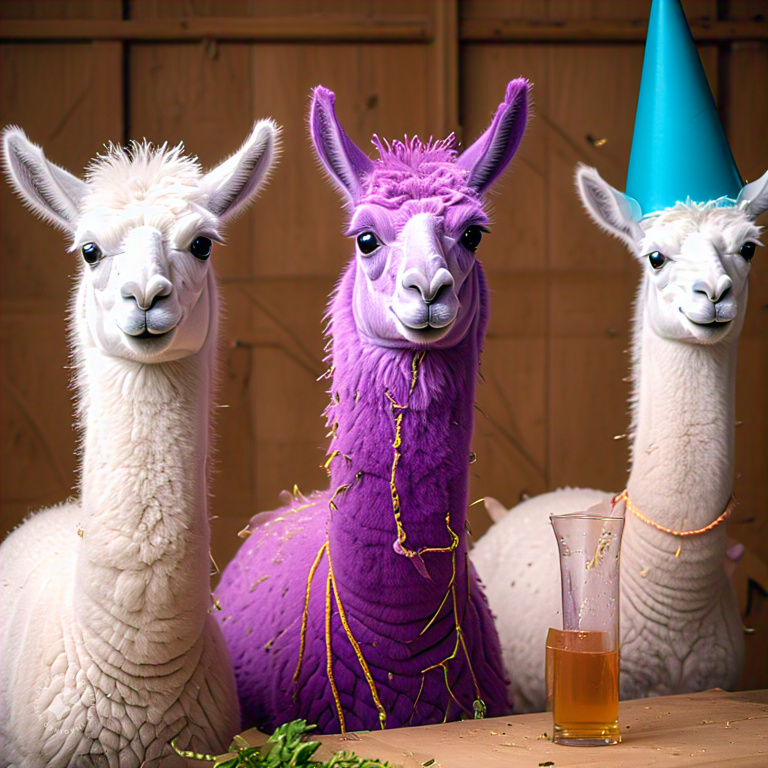

In [29]:
!curl -O https://raw.githubusercontent.com/meta-llama/llama-models/refs/heads/main/Llama_Repo.jpeg

from IPython.display import Image
Image("Llama_Repo.jpeg", width=256, height=256)



In [30]:
import base64
vision_model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        base64_string = base64.b64encode(image_file.read()).decode("utf-8")
        base64_url = f"data:image/png;base64,{base64_string}"
        return base64_url

### 4.2 Using Llama Stack Inference API for multimodal inference

In [31]:
response = client.inference.chat_completion(
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": {
                        "url": {
                            "uri": encode_image("Llama_Repo.jpeg")
                        }
                    }
                },
                {
                    "type": "text",
                    "text": "How many different colors are those llamas? What are those colors?",
                }
            ]
        }
    ],
    model_id=vision_model_id,
    stream=False,
)

print(response.completion_message.content)

There are three llamas in the image. The llama in the middle is purple, the llama on the left is white, and the llama on the right is also white, but it is wearing a blue party hat. Therefore, there are two different colors of llama in the image: purple and white.
